(xarray-intro)=
# Xarray - brief introduction

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Xarray introduction.ipynb`
```

The Quantify dataset is based on {doc}`Xarray <xarray:index>`.
This subsection is a very brief overview of some concepts and functionalities of xarray.
Here we use only pure xarray concepts and terminology.

This is not intended as an extensive introduction to xarray.
Please consult the {doc}`xarray documentation <xarray:index>` if you never used it
before (it has very neat features!).

In [1]:
import numpy as np
from rich import pretty
import xarray as xr

pretty.install()

There are different ways to create a new xarray dataset.
Below we exemplify a few of them to showcase specific functionalities.

An xarray dataset has **Dimensions** and **Variables**. Variables "lie" along at least
one dimension:

In [2]:
n = 5

values_pos = np.linspace(-5, 5, n)
dimensions_pos = ("position_x",)
# the "unit" and "long_name" are a convention for automatic plotting
attrs_pos = dict(unit="m", long_name="Position")  # attributes of this data variable

values_vel = np.linspace(0, 10, n)
dimensions_vel = ("velocity_x",)
attrs_vel = dict(unit="m/s", long_name="Velocity")

data_vars = dict(
    position=(dimensions_pos, values_pos, attrs_pos),
    velocity=(dimensions_vel, values_vel, attrs_vel),
)

dataset_attrs = dict(my_attribute_name="some meta information")

dataset = xr.Dataset(
    data_vars=data_vars,
    attrs=dataset_attrs,
)  # dataset attributes
dataset

<xarray.Dataset> Size: 80B
Dimensions:   (position_x: 5, velocity_x: 5)
Dimensions without coordinates: position_x, velocity_x
Data variables:
    position  (position_x) float64 40B -5.0 -2.5 0.0 2.5 5.0
    velocity  (velocity_x) float64 40B 0.0 2.5 5.0 7.5 10.0
Attributes:
    my_attribute_name:  some meta information

In [3]:
dataset.dims

FrozenMappingWarningOnValuesAccess({'position_x': 5, 'velocity_x': 5})

In [4]:
dataset.variables


Frozen({'position': <xarray.Variable (position_x: 5)> Size: 40B
array([-5. , -2.5,  0. ,  2.5,  5. ])
Attributes:
    unit:       m
    long_name:  Position, 'velocity': <xarray.Variable (velocity_x: 5)> Size: 40B
array([ 0. ,  2.5,  5. ,  7.5, 10. ])
Attributes:
    unit:       m/s
    long_name:  Velocity})

A variable can be "promoted" to (or defined as) a **Coordinate** for its dimension(s):

In [5]:
values_vel = 1 + values_pos**2
data_vars = dict(
    position=(dimensions_pos, values_pos, attrs_pos),
    # now the velocity array "lies" along the same dimension as the position array
    velocity=(dimensions_pos, values_vel, attrs_vel),
)
dataset = xr.Dataset(
    data_vars=data_vars,
    # NB We could set "position" as a coordinate directly when creating the dataset:
    # coords=dict(position=(dimensions_pos, values_pos, attrs_pos)),
    attrs=dataset_attrs,
)

# Promote the "position" variable to a coordinate:
# In general, most of the functions that modify the structure of the xarray dataset will
# return a new object, hence the assignment
dataset = dataset.set_coords(["position"])
dataset

<xarray.Dataset> Size: 80B
Dimensions:   (position_x: 5)
Coordinates:
    position  (position_x) float64 40B -5.0 -2.5 0.0 2.5 5.0
Dimensions without coordinates: position_x
Data variables:
    velocity  (position_x) float64 40B 26.0 7.25 1.0 7.25 26.0
Attributes:
    my_attribute_name:  some meta information

In [6]:
dataset.coords["position"]

<xarray.DataArray 'position' (position_x: 5)> Size: 40B
array([-5. , -2.5,  0. ,  2.5,  5. ])
Coordinates:
    position  (position_x) float64 40B -5.0 -2.5 0.0 2.5 5.0
Dimensions without coordinates: position_x
Attributes:
    unit:       m
    long_name:  Position

Note that the xarray coordinates are available as variables as well:

In [7]:
dataset.variables["position"]

<xarray.Variable (position_x: 5)> Size: 40B
array([-5. , -2.5,  0. ,  2.5,  5. ])
Attributes:
    unit:       m
    long_name:  Position

Which, on its own, might not be very useful yet, however, xarray coordinates can be set
to **index** other variables ({func}`~quantify.data.handling.to_gridded_dataset`
does this for the Quantify dataset), as shown below (note the bold font in the output!):

In [8]:
dataset = dataset.set_index({"position_x": "position"})
dataset.position_x.attrs["unit"] = "m"
dataset.position_x.attrs["long_name"] = "Position x"
dataset

<xarray.Dataset> Size: 80B
Dimensions:     (position_x: 5)
Coordinates:
  * position_x  (position_x) float64 40B -5.0 -2.5 0.0 2.5 5.0
Data variables:
    velocity    (position_x) float64 40B 26.0 7.25 1.0 7.25 26.0
Attributes:
    my_attribute_name:  some meta information

At this point the reader might get very confused. In an attempt to clarify, we now have
a dimension, a coordinate and a variable with the same name `"position_x"`.

In [9]:
(
    "position_x" in dataset.dims,
    "position_x" in dataset.coords,
    "position_x" in dataset.variables,
)

(True, True, True)

In [10]:
dataset.dims["position_x"]

C:\Users\gabri\AppData\Local\Temp\ipykernel_29564\457231006.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dataset.dims["position_x"]


5

In [11]:
dataset.coords["position_x"]

<xarray.DataArray 'position_x' (position_x: 5)> Size: 40B
array([-5. , -2.5,  0. ,  2.5,  5. ])
Coordinates:
  * position_x  (position_x) float64 40B -5.0 -2.5 0.0 2.5 5.0
Attributes:
    unit:       m
    long_name:  Position x

In [12]:
dataset.variables["position_x"]

<xarray.IndexVariable 'position_x' (position_x: 5)> Size: 40B
array([-5. , -2.5,  0. ,  2.5,  5. ])
Attributes:
    unit:       m
    long_name:  Position x

Here the intention is to make the reader aware of this peculiar behavior.
Please consult the {doc}`xarray documentation <xarray:index>` for more details.

An example of how this can be useful is to retrieve data from an xarray variable using
one of its coordinates to select the desired entries:

In [13]:
dataset.velocity

<xarray.DataArray 'velocity' (position_x: 5)> Size: 40B
array([26.  ,  7.25,  1.  ,  7.25, 26.  ])
Coordinates:
  * position_x  (position_x) float64 40B -5.0 -2.5 0.0 2.5 5.0
Attributes:
    unit:       m/s
    long_name:  Velocity

In [14]:
retrieved_value = dataset.velocity.sel(position_x=2.5)
retrieved_value

<xarray.DataArray 'velocity' ()> Size: 8B
array(7.25)
Coordinates:
    position_x  float64 8B 2.5
Attributes:
    unit:       m/s
    long_name:  Velocity

Note that without this feature we would have to keep track of numpy integer indexes to
retrieve the desired data:

In [15]:
dataset.velocity.values[3], retrieved_value.values == dataset.velocity.values[3]

(7.25, True)

One of the great features of xarray is automatic plotting (explore the xarray
documentation for more advanced capabilities!):

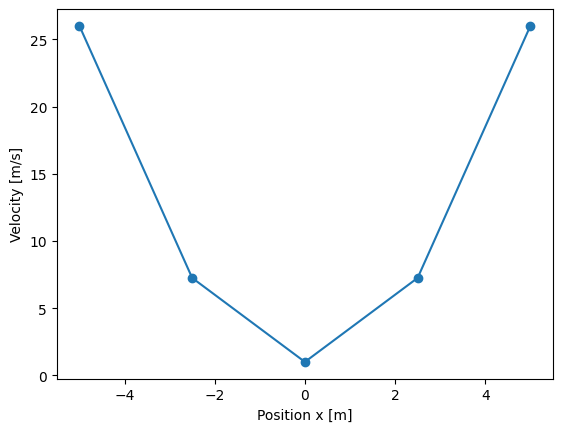

In [16]:
_ = dataset.velocity.plot(marker="o")

Note the automatic labels and unit.